In [2]:
class Ability:
    def __init__(self, id, name, CD, GCD, castTime, dmg):
        self.id = id
        self.name = name
        self.CD = CD
        self.GCD = GCD
        self.castTime = castTime
        self.dmg = dmg
    
    def hasteUpdate(self, haste):
        self.castTime = self.castTime / haste
        if self.name == "autoShot":
            self.CD = self.CD / haste

autoShot = Ability(0, "autoShot", 2.5, False, 0.5, 1369.15) # 2.5 + 0.5 = 3.0 => attack speed written on the tooltip
steadyShot = Ability(1, "steadyShot", 0, True, 1.5, 1414.53)
multiShot = Ability(2, "multiShot", 10, True, 0.5, 1601.86)
arcaneShot = Ability(3, "arcaneShot", 6, True, 0, 1099.11)

In [3]:
import matplotlib.pyplot as plt

class Rotation:
    def __init__(self, name, abilities):
        self.name = name
        self.abilities = abilities

    # Method that breaks down all the timers for abilities, CDs and GCDs, as well as total rotation length and time lost before cycling again
    def timers(self, haste, printActivated):
        
        # Initialization of outputs
        GCDs = []
        abilities = []
        abilityCDs = []

        # Initialization of loop variables
        currentTimer = 0 # timer
        currentGCD = 0 # current GCD
        currentAbilityCDs = [0, 0, 0, 0] # current CD for autoShot, steadyShot, multiShot, arcaneShot 

        # Information to be stored to help close the rotation as tight as possible
        firstGCD = 10000 # timing of the first GCD
        firstCast = [10000, 10000, 10000, 10000] # timing at which a spell will be cast for the first time in the rotation

        # Main loop
        for ability in self.abilities:

            # 1) Add an ability to the "abilities" array and update timer
            if(ability.GCD):
                # for spells, wait for gcd and cd to be available and then add the cast time
                timeUntilCastStart = max(currentAbilityCDs[ability.id], currentGCD, 0)
                timeToCast = ability.castTime / haste
            else:
                # for autoShots, wait for the auto swing timer to be available
                timeUntilCastStart = max(currentAbilityCDs[ability.id], 0)
                timeToCast = ability.castTime / haste
            # Update current timer
            currentTimer = currentTimer + timeUntilCastStart + timeToCast
            # Record ability
            abilities.append([ability.name, currentTimer - timeToCast, currentTimer, currentAbilityCDs[ability.id]-timeUntilCastStart])

            # 2) Update GCD
            if(ability.GCD):
                # A GCD of 1.5 secs is triggered at the beginning of the cast
                currentGCD = 1.5 - timeToCast
                # Record GCD
                GCDs.append([currentTimer - timeToCast, currentTimer - timeToCast + 1.5])
            else:
                # For autoShots, no GCD is triggered
                currentGCD = currentGCD - (timeUntilCastStart + timeToCast)

            # 3) Update CDs
            for i in range(4):
                if i == ability.id:
                    # spell CD is triggered at the end of the cast
                    if ability.name == "autoShot":
                        # autoShot CD/swing timer is hastened with haste
                        currentAbilityCDs[i] = ability.CD / haste  
                    else:
                        currentAbilityCDs[i] = ability.CD
                    # Record CD
                    abilityCDs.append([ability.name, currentTimer, currentTimer + currentAbilityCDs[i]])
                else:
                    currentAbilityCDs[i] = currentAbilityCDs[i] - (timeUntilCastStart + timeToCast)

            # 4) Input firstGCD if relevant
            if firstGCD == 10000 and ability.GCD:
                firstGCD = currentTimer - timeToCast

            # 5) Input firstCast array if relevant
            if firstCast[ability.id] == 10000:
                firstCast[ability.id] = currentTimer - timeToCast

            # 6) Print the summary of this spell if required
            if printActivated:
                print("cast " + ability.name + " from " + str(round(currentTimer-timeToCast,2)) +" to " + str(round(currentTimer,2)))

        # Loop is closed
        
        # Add a remaining CD to make sure the rotation can be cycled through
        remainingCD = max (0, currentGCD-firstGCD, currentAbilityCDs[0]-firstCast[0], currentAbilityCDs[1]-firstCast[1], currentAbilityCDs[2]-firstCast[2], currentAbilityCDs[3]-firstCast[3])

        # Prepare and send output
        currentTimer = currentTimer + remainingCD
        return(abilities, abilityCDs, GCDs, currentTimer, round(remainingCD,2))

    def dps(self, haste, printActivated):
        
        currentDamage = 0 # Initialization of loop variable
        
        for ability in self.abilities:
            currentDamage = currentDamage + ability.dmg
        
        totalTimer = self.timers(haste, printActivated)[3]
        dps = currentDamage / totalTimer    
       
        return(round(dps))

    def dpsArray(self, maxHaste):
        dpsArray=[]
        for i in range(1000):
            haste = 1 + (maxHaste - 1) * (i/1000)
            dpsArray.append(self.dps(haste, False))
        return dpsArray

    def efficiency(self, haste):
        timers = self.timers(haste, False)
        abilities = timers[0]
        GCDs = timers[2]
        duration = timers[3]
        
        GCDEfficiency = len(GCDs) * 1.5 / duration
        
        totalPushback = 0
        for ability in abilities:
            if (ability[0] == "autoShot"):
                totalPushback = totalPushback - ability[3]
        autoShotEfficiency = 1-totalPushback/duration

        return (GCDEfficiency, autoShotEfficiency)

    # Create a visual representation of a rotation - Credits to Diziet
    def visualize(self, haste):

        # rotation characteristics
        timers = self.timers(haste, False)
        abilities = timers[0]
        GCDs = timers[2]
        dps = round(self.dps(haste, False),2)
        unhastedSwing = round(autoShot.CD + autoShot.castTime,2)
        eWS = round(unhastedSwing/haste,2)
        duration = round(timers[3],2)
        GCDEfficiency, autoShotEfficiency =  self.efficiency(haste)

        # plot variables
        autocolor = 'firebrick'
        delaycolor = 'lightcoral'
        steadycolor = 'deepskyblue'
        arcanecolor ='green'
        multicolor = 'red'
        raptorcolor = 'sandybrown'

        # initialize plot
        fig, ax = plt.subplots(figsize=(10,5), dpi=150)

        # Draw each ability
        for gcd in GCDs:
            ax.bar(gcd[0], 0.8, 1.5, 2.1, facecolor='white', edgecolor='black', align='edge')
        for i in range(len(abilities)):
            if(abilities[i][0]=="autoShot"):
                ax.bar(abilities[i][1], 0.8, abilities[i][2]-abilities[i][1], 0.1, facecolor='white', edgecolor='firebrick', align='edge')
                autoShotDelay = - abilities[i][3]
                if(autoShotDelay > 0):
                    ax.bar(abilities[i][1], 0.2, - autoShotDelay, 0.4, facecolor='white', edgecolor='lightcoral', align='edge')
            elif(abilities[i][0]=="steadyShot"):
                ax.bar(abilities[i][1], 0.8, abilities[i][2]-abilities[i][1], 1.1, facecolor='white', edgecolor='deepskyblue', align='edge')
            elif(abilities[i][0]=="multiShot"):
                ax.bar(abilities[i][1], 0.8, abilities[i][2]-abilities[i][1], 1.1, facecolor='white', edgecolor='red', align='edge')
            elif(abilities[i][0]=="arcaneShot"):
                ax.bar(abilities[i][1], 0.8, 0.1, 1.1, facecolor='white', edgecolor='green', align='edge')

        # Finalize plot
        ax.set_ylim(0, 3)
        ax.set_yticks([0.5, 1.5, 2.5])
        ax.set_yticklabels(['Auto', 'Cast', 'GCD'])
        ax.set_xlabel('time [s]')
        colors = {'auto':autocolor, 'auto delay':delaycolor, \
                    'steady':steadycolor, 'arcane':arcanecolor, \
                    'multi':multicolor, 'raptor/melee':raptorcolor}
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc='upper left')

        rota = f"Rotation: {self.name}\nRanged Speed: {unhastedSwing}\neWS: {eWS}\nDuration: {duration}\nDps: {dps}\nGCD efficiency: {round(GCDEfficiency,2)*100}%\nAuto efficiency: {round(autoShotEfficiency,2)*100}%"
        plt.annotate(rota,(1.01,0.3), xycoords='axes fraction')
        plt.show()


In [4]:
# Definition of rotations
_11 = Rotation("1:1", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot])
_11wMS = Rotation("1:1 w/ MS", [autoShot, multiShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot])
_12 = Rotation("1:2", [autoShot, steadyShot, autoShot])
_12wMS = Rotation("1:2 w/ MS", [autoShot, multiShot, autoShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot])
_13 = Rotation("1:3", [autoShot, steadyShot, autoShot, autoShot])
_14 = Rotation("1:4", [autoShot, steadyShot, autoShot, autoShot, autoShot])
_5511 = Rotation("5:5:1:1", [autoShot, steadyShot, multiShot, autoShot, steadyShot, autoShot, steadyShot, arcaneShot, autoShot, steadyShot, autoShot, steadyShot])
_5611 = Rotation("5:6:1:1", [autoShot, steadyShot, arcaneShot, autoShot, multiShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot])
_21 = Rotation("2:1", [autoShot, steadyShot, steadyShot])
_21wMS = Rotation("2:1 w/ MS", [autoShot, steadyShot, multiShot, autoShot, steadyShot, steadyShot, autoShot, steadyShot, steadyShot, autoShot, steadyShot, steadyShot])
_21wMSAS = Rotation("2:1 w/ MS and AS", [autoShot, steadyShot, multiShot, autoShot, steadyShot, steadyShot, autoShot, steadyShot, arcaneShot, autoShot, steadyShot, steadyShot])
_34 = Rotation("3:4", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot])
_45 = Rotation("4:5", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot])
_23 = Rotation("2:3", [autoShot, steadyShot, autoShot, steadyShot, autoShot])
_23wMS = Rotation("2:3 wMS", [autoShot, steadyShot, autoShot, multiShot, autoShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, autoShot, steadyShot, autoShot, steadyShot, autoShot])
_56 = Rotation("5:6", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot])
_351 = Rotation("3:5:1", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot,  multiShot, autoShot])
_461 = Rotation("4:6:1", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, multiShot, autoShot])
_571 = Rotation("5:7:1", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, multiShot, autoShot])
_681 = Rotation("6:8:1", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, multiShot, autoShot])
_691 = Rotation("6:9:1", [autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, multiShot, autoShot, autoShot, steadyShot, autoShot, steadyShot, autoShot, steadyShot, autoShot])

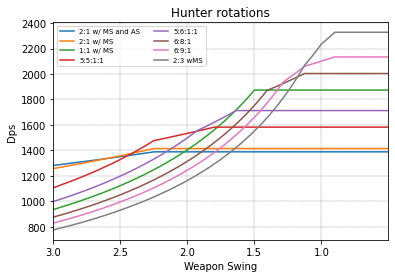

In [7]:
import matplotlib.pyplot as plt

# List of rotations to plot
rotations = (_21wMSAS, _21wMS, _11wMS, _5511, _5611, _681, _691, _23wMS)

def eWSPlot(rotations, maxHaste):
    eWS=[]
    for i in range(1000):
        haste = 1 + (maxHaste-1)*i/1000
        eWS.append(3/haste)
    for rotation in rotations:
        plt.plot(eWS, rotation.dpsArray(maxHaste), label=rotation.name)
    plt.xlabel("Weapon Swing")
    plt.ylabel("Dps")
    plt.title("Hunter rotations")
    plt.xlim(max(eWS), min(eWS))
    plt.legend(frameon=True, fontsize="x-small", loc='upper left', ncol=2)
    plt.grid(color='black', linestyle='dashed', linewidth=0.2)

def hastePlot(rotations, maxHaste):
    haste=[]
    for i in range(1000):
        haste.append(1 + (maxHaste-1)*i/1000)
    for rotation in rotations:
        plt.plot(haste, rotation.dpsArray(maxHaste), label=rotation.name)
    plt.xlabel("Haste")
    plt.ylabel("Dps")
    plt.title("Hunter rotations")
    plt.legend(frameon=True, fontsize="x-small", loc='upper left', ncol=2)
    plt.grid(color='black', linestyle='dashed', linewidth=0.2)

eWSPlot(rotations, 6)

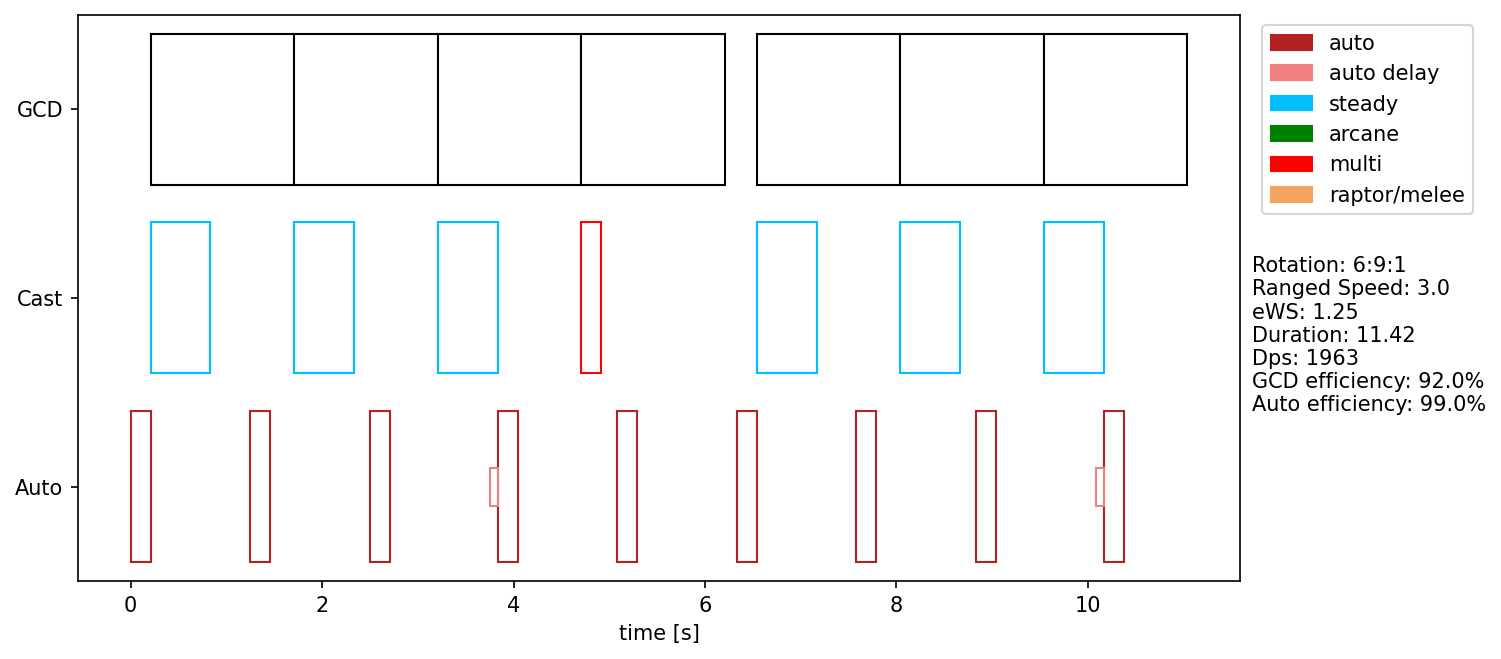

In [8]:
# single rotation visualization tool
_691.visualize(2.4)